In [1]:
!pip install pandas pyspark matplotlib

  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl (8.1 MB)


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TestSpark").getOrCreate()
print("✅ Spark started successfully!")
spark.stop()


✅ Spark started successfully!


# 🧠 PySpark Project — COVID-19 Big Data Analysis

---

### 👩‍💻 Author: **Preeti Dhyani**

---

## 🎯 Goal

Demonstrate how **PySpark** can efficiently handle **large datasets** by analyzing a **COVID-19 dataset (CSV file)**.

---

## ⚙️ Requirements

To successfully run this project, make sure the following tools are installed:

- 🐍 **Python (Anaconda recommended)**
- ☕ **Java JDK 8 or later**
- 🔥 **PySpark**  


✅ Spark session started
Spark version: 4.0.1

✅ Data loaded successfully!
Total rows: 49068
root
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Active: integer (nullable = true)
 |-- WHO Region: string (nullable = true)

+--------------+--------------+--------+---------+----------+---------+------+---------+------+---------------------+
|Province/State|Country/Region|Lat     |Long     |Date      |Confirmed|Deaths|Recovered|Active|WHO Region           |
+--------------+--------------+--------+---------+----------+---------+------+---------+------+---------------------+
|NULL          |Afghanistan   |33.93911|67.709953|2020-01-22|0        |0     |0        |0     |Eastern Mediterranean|
|NULL          |Albania      

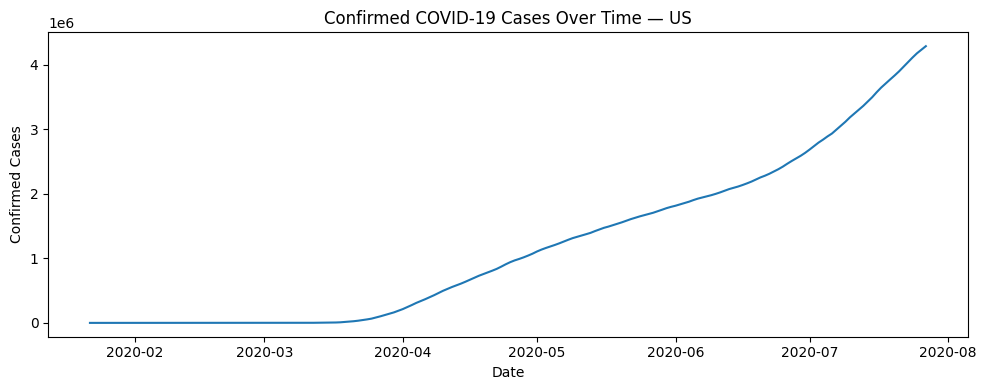


⚙️ Demonstrating caching and repartitioning...
DataFrame cached in memory.
Repartitioned to 4 partitions

✅ Results saved to: C:\Users\dell\Downloads\top10_countries_confirmed.csv

✅ Analysis complete. Spark session stopped successfully.


In [4]:


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, to_date, desc
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------------------------------------
# 1. Create a Spark Session
# ----------------------------------------------------------
spark = SparkSession.builder \
    .appName("BeginnerCovidAnalysis") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print("✅ Spark session started")
print("Spark version:", spark.version)

# ----------------------------------------------------------
# 2. Load the dataset
# ----------------------------------------------------------
# 🔽 Change this to your local file path on Windows:
csv_path = r"C:\Users\dell\Downloads\covid_19.csv"

df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .csv(csv_path)

print("\n✅ Data loaded successfully!")
print("Total rows:", df.count())
df.printSchema()
df.show(5, truncate=False)

# ----------------------------------------------------------
# 3. Detect date, country, and confirmed columns
# ----------------------------------------------------------
possible_date_cols = [c for c in df.columns if 'date' in c.lower()]
possible_confirm_cols = [c for c in df.columns if 'confirm' in c.lower()]
possible_country_cols = [c for c in df.columns if 'country' in c.lower() or 'region' in c.lower()]

print("\n📅 Detected date-like columns:", possible_date_cols)
print("🏳️ Detected country-like columns:", possible_country_cols)
print("🧮 Detected confirm-like columns:", possible_confirm_cols)

# Fallback selections if auto-detection fails
date_col = possible_date_cols[0] if possible_date_cols else df.columns[0]
confirm_col = possible_confirm_cols[0] if possible_confirm_cols else df.columns[-1]
country_col = possible_country_cols[0] if possible_country_cols else df.columns[1]

# ----------------------------------------------------------
# 4. Parse date and add simple date features
# ----------------------------------------------------------
df = df.withColumn("date_parsed", to_date(col(date_col)))
df = df.withColumn("year", col("date_parsed").substr(1, 4).cast("int"))
df = df.withColumn("month", col("date_parsed").substr(6, 2).cast("int"))

print("\n✅ Date column parsed and features created")
df.select("date_parsed", "year", "month").show(5)

# ----------------------------------------------------------
# 5. Top countries by total confirmed cases
# ----------------------------------------------------------
agg_country = df.groupBy(country_col).agg(_sum(col(confirm_col)).alias("total_confirmed")) \
                .orderBy(desc("total_confirmed"))

print("\n🌍 Top 10 countries by total confirmed cases:")
agg_country.show(10, truncate=False)

# ----------------------------------------------------------
# 6. Plot time series for top country
# ----------------------------------------------------------
top_country_row = agg_country.limit(1).collect()[0]
top_country = top_country_row[0]

print("\n📈 Generating time series for:", top_country)

time_series = df.filter(col(country_col) == top_country) \
                .groupBy("date_parsed") \
                .agg(_sum(col(confirm_col)).alias("confirmed")) \
                .orderBy("date_parsed")

pdf = time_series.toPandas()

plt.figure(figsize=(10, 4))
plt.plot(pd.to_datetime(pdf["date_parsed"]), pdf["confirmed"])
plt.title(f"Confirmed COVID-19 Cases Over Time — {top_country}")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 7. Demonstrate caching and repartitioning
# ----------------------------------------------------------
print("\n⚙️ Demonstrating caching and repartitioning...")

df.cache()
_ = df.count()
print("DataFrame cached in memory.")

df_repart = df.repartition(4)
print("Repartitioned to", df_repart.rdd.getNumPartitions(), "partitions")

# ----------------------------------------------------------
# 8. Save summary results
# ----------------------------------------------------------
top10 = agg_country.limit(10).toPandas()
out_path = r"C:\Users\dell\Downloads\top10_countries_confirmed.csv"
top10.to_csv(out_path, index=False)

print("\n✅ Results saved to:", out_path)

# ----------------------------------------------------------
# 9. End session
# ----------------------------------------------------------
spark.stop()
print("\n✅ Analysis complete. Spark session stopped successfully.")
